**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from model trained with tn nuclear data, further train the model with resized K's data that is cut into 25x7 512x512 patches. There are a total of 12,574 training instances.<br>
The difference between this note book and DeepCell_tn_nuclear_K2 is that resizing of K's training images is done with mpp=1 instead of 1.3.<br>
200 epochs, semanticdatagenerator, resized<br>
Best mAP 0.44 at mpp=1.3

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
INPUT_PATH="images/training_resized1_512x512/"
model_name = 'tn1.0_nuclear_K_512x512resized1' 
model_path = '{}.h5'.format(model_name)
epochs=200 # 20 sec per step 

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [3]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))

112


In [4]:
imgs = [io.imread(CURR_IM_NAME) for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

2022-11-04 10:36:35.209418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-04 10:36:35.249970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-04 10:36:35.252691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(112, 512, 512, 1)
(112, 512, 512, 1)


In [5]:
np.max(masks) # sanity check

2688

In [6]:
# create dataloader
seed=0
min_objects = 5

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

199356


In [7]:
mask_cnt=[len(np.unique(x)) for x in masks]
print(np.sort(mask_cnt))
indices = []
indices.extend([i for i, x in enumerate(mask_cnt) if x == 4])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 9])
print(indices)

[  4   9  12  12  20  20  21  22  24  25  25  33  39  41  47  50  51  54
  55  58  61  62  62  64  65  66  68  70  74  88  89  90  96 101 104 106
 107 107 110 111 111 113 114 115 115 117 120 121 121 126 127 128 129 130
 133 141 141 148 150 155 155 162 165 165 167 167 167 168 169 173 173 176
 178 180 181 184 186 188 188 190 196 197 202 211 212 214 218 220 224 226
 241 241 243 246 260 262 269 270 274 275 282 284 290 291 298 302 303 304
 332 338 355 362]
[45, 102]


In [8]:
[FILENAMES[x] for x in indices]

['images/training_resized1_512x512/M872956_JML_Position8_CD8_train3_img.png',
 'images/training_resized1_512x512/M872956_JML_Position8_CD8_train7_img.png']

images/training_resized1_512x512/M872956_JML_Position8_CD8_train3_img.png


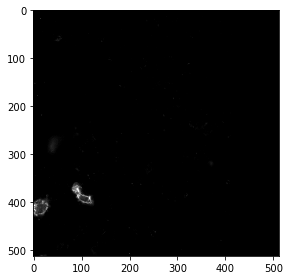

/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


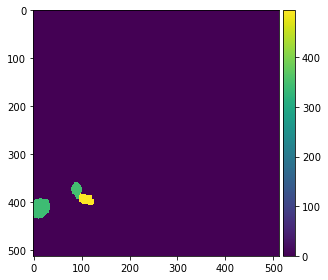

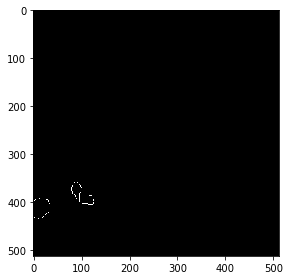

[  0 342 347 495]
[  0 342 347 495]


In [9]:
i=45
print(FILENAMES[i])
# plt.subplot(1, 3, 1) 
io.imshow(io.imread(FILENAMES[i]))
plt.show()
# plt.subplot(1, 3, 2) 
io.imshow(io.imread(FILENAMES[i].replace("_img","_masks")))
plt.show()
# plt.subplot(1, 3, 3) 
tmp=syotil.masks_to_outlines(io.imread(FILENAMES[i].replace("_img","_masks")))
io.imshow(tmp)
plt.show()
print(np.unique(masks[i]))
print(np.unique(masks[i][1:510,1:510]))

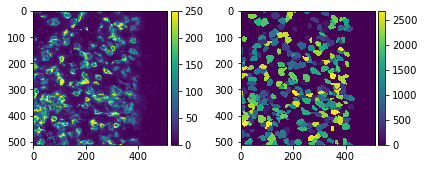

In [10]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [11]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-11-03 22:16:37.010723: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [12]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    # monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-03 22:16:43.997407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-03 22:16:43.998398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-03 22:16:43.999385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/200


2022-11-03 22:16:59.402183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


27/27 [==============================] - 42s 799ms/step - loss: 0.0184 - semantic_0_loss: 0.0057 - semantic_1_loss: 0.0106 - semantic_2_loss: 0.0022 - lr: 1.0000e-04
Epoch 2/200
27/27 [==============================] - 18s 654ms/step - loss: 0.0163 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0096 - semantic_2_loss: 0.0017 - lr: 9.9000e-05
Epoch 3/200
27/27 [==============================] - 18s 657ms/step - loss: 0.0165 - semantic_0_loss: 0.0051 - semantic_1_loss: 0.0097 - semantic_2_loss: 0.0016 - lr: 9.8010e-05
Epoch 4/200
27/27 [==============================] - 18s 645ms/step - loss: 0.0159 - semantic_0_loss: 0.0049 - semantic_1_loss: 0.0094 - semantic_2_loss: 0.0016 - lr: 9.7030e-05
Epoch 5/200
27/27 [==============================] - 18s 649ms/step - loss: 0.0159 - semantic_0_loss: 0.0050 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0016 - lr: 9.6060e-05
Epoch 6/200
27/27 [==============================] - 18s 652ms/step - loss: 0.0157 - semantic_0_loss: 0.0049 - semantic_1_

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [11]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

2022-11-04 10:36:42.312314: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [12]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [13]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [16]:
# more detailed mapping of image_mpp parameter
mpps=np.linspace(start=.9, stop=1.4, num=6)

AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)
print(AP_mat)
print(mpps)
[x.index(np.max(x)) for x in AP_mat]

M926910_CFL_Position7_CD3_test_img.png


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


M872956_JML_Position10_CD3_test_img.png
M872956_JML_Position8_CD8_test_img.png
M926910_CFL_Position13_CD3_test_img.png
M872956_JML_Position8_CD3_test_img.png
M872956_JML_Position8_CD4_test_img.png
M872956_JML_Position9_CD3_test_img.png
[[0.3562091503267974, 0.3601236476043277, 0.37065052950075644, 0.3784977908689249, 0.37780898876404495, 0.375], [0.3157894736842105, 0.3805309734513274, 0.4103448275862069, 0.42953020134228187, 0.4208, 0.4182098765432099], [0.46808510638297873, 0.47474747474747475, 0.47058823529411764, 0.4976303317535545, 0.4774774774774775, 0.4495798319327731], [0.27692307692307694, 0.3099273607748184, 0.3333333333333333, 0.3424036281179138, 0.32181425485961124, 0.33059548254620125], [0.45569620253164556, 0.503584229390681, 0.5376532399299475, 0.5108514190317195, 0.4726134585289515, 0.48396946564885496], [0.5746835443037974, 0.5777777777777777, 0.5584725536992841, 0.5279642058165548, 0.4665271966527197, 0.4601593625498008], [0.3155737704918033, 0.3333333333333333, 0.398

[3, 3, 3, 3, 2, 1, 5]

In [15]:
mpp_select=1.2

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.3784977908689249, 'M872956_JML_Position10_CD3_test_img.png': 0.42953020134228187, 'M872956_JML_Position8_CD8_test_img.png': 0.4976303317535545, 'M926910_CFL_Position13_CD3_test_img.png': 0.3424036281179138, 'M872956_JML_Position8_CD3_test_img.png': 0.5108514190317195, 'M872956_JML_P

In [18]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.360124
1  M872956_JML_Position10_CD3_test_img.png  0.380531
2   M872956_JML_Position8_CD8_test_img.png  0.474747
3  M926910_CFL_Position13_CD3_test_img.png  0.309927
4   M872956_JML_Position8_CD3_test_img.png  0.503584
5   M872956_JML_Position8_CD4_test_img.png  0.577778
6   M872956_JML_Position9_CD3_test_img.png  0.333333
7                                      mAP  0.420004


**mAP**<br>
image_mpp=1:   0.42<br>
image_mpp=1.2: 0.44<br>
image_mpp=1.3: 0.44<br>